In [1]:
%matplotlib inline
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import seaborn as sns; sns.set_style("dark")
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (8,6)
from IPython.display import display
from pprint import pprint

from sklearn.model_selection import train_test_split

from ml_tools import make_cross_validation, make_grid_search_clf, plot_roc_curve

### Data Preparation

In [2]:
def load_data(filename):
    return pd.read_csv("data/" + filename)

target_name = "multiplier"
data = pd.concat([load_data("data2014.csv"), load_data("data2015.csv")])
X, y = data.drop(target_name, axis=1), data[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

Prepare data for classification

In [3]:
def cut(X, filter_values, log=False):
    if log: X = np.log2(X)
    X_cut = pd.cut(X, bins=filter_values)
    X_cut = X_cut.map(lambda x: np.argmax(filter_values > x.left) - 1)
    X_cut.loc[X_cut.isnull()] = X[X_cut.isnull()].map(lambda x: len(filter_values) - 2 if x > filter_values[-1] else 0)
    return X_cut

# bins = np.linspace(-2, 2, 5)
# bins = np.logspace(-2, 2, 5, base=2)
bins = np.linspace(0, 2, 3)

y_train_bins = cut(y_train, bins, log=False)
y_test_bins = cut(y_test, bins)

/home/quent/.local/bin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


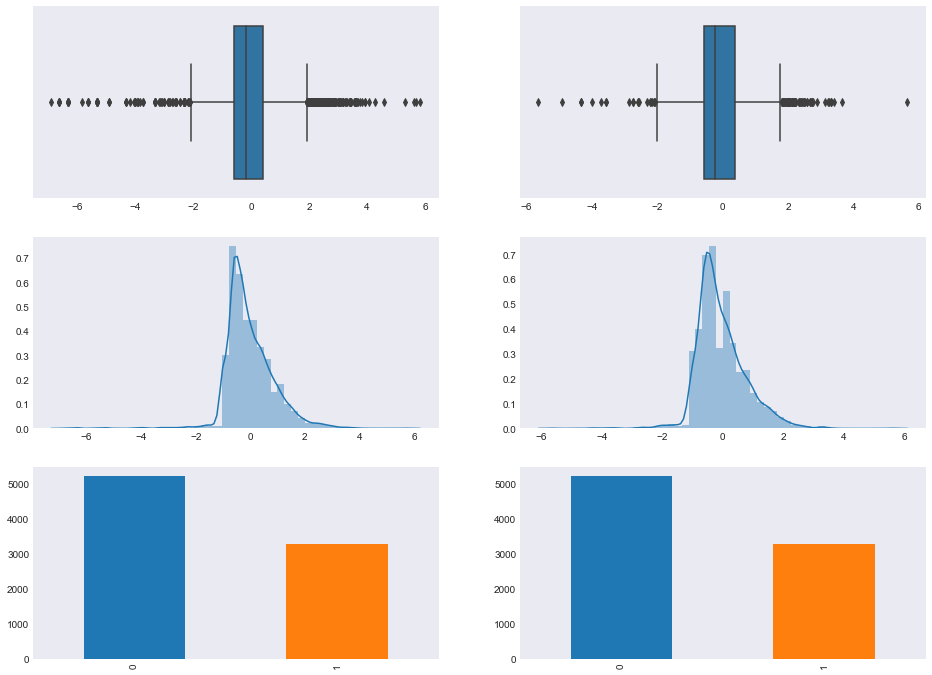

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(16,12))
for i, (series, series_bin) in enumerate(zip([y_train, y_test], [y_train_bins, y_train_bins])):
    sns.boxplot(np.log2(series), ax=axs[0, i % 3])
    sns.distplot(np.log2(series), ax=axs[1, i % 3])
    series_bin.value_counts().sort_index().plot.bar(ax=axs[2, i % 3])
    [ax.set_xlabel("") for ax in axs[:, i % 3]]

### Classification

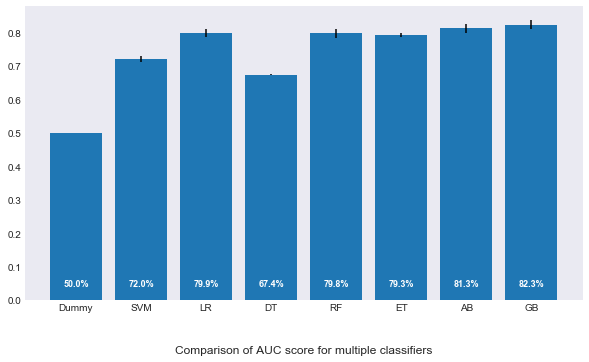

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

scoring = "roc_auc"

models = [
    
    ("Dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()), 
    ("LR", LogisticRegression()),
    ("DT", DecisionTreeClassifier()), 
    ("RF", RandomForestClassifier()),
    ("ET", ExtraTreesClassifier()),
    ("AB", AdaBoostClassifier()),
    ("GB", GradientBoostingClassifier())
    
]

cv_results = make_cross_validation(models, scoring, X_train, y_train_bins)

In [6]:
n_features = X_train.shape[1]

base_dt = DecisionTreeClassifier(criterion='entropy', splitter='random')  #max_features="auto", max_depth=None)

classifiers = [
#     ("LogisticRegression", LogisticRegression()), 
    ("AdaBoost", AdaBoostClassifier(base_estimator=base_dt)),
#     ("GradientBoosting", GradientBoostingClassifier())
]

clf_params = {
    "LogisticRegression": {
        "penalty": ["l1", "l2"], 
        "C": np.logspace(-3, 3, 7), 
        "class_weight":["balanced", None]
    },
    
    "AdaBoost": {
#         "base_estimator__criterion" : ["gini", "entropy"],
#         "base_estimator__splitter" :   ["best", "random"],
        "base_estimator__max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "base_estimator__max_depth": range(3, 16, 4),
        "learning_rate": np.logspace(-2, 1, 4),
        "n_estimators": range(40, 80, 10)
    },
    
    "GradientBoosting": {

    },
}

best_models, gs_results = make_grid_search_clf(classifiers, clf_params, X_train, y_train_bins, X_test, y_test_bins)


AdaBoost:

	Accuracy: 78.23%
	AUC Score (Train set): 75.70%
	AUC Score (Test set): 75.81%

             precision    recall  f1-score   support

          0       0.81      0.85      0.83      1776
          1       0.73      0.66      0.69      1053

avg / total       0.78      0.78      0.78      2829

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random'),
          learning_rate=0.01, n_estimators=70, random_state=None) 



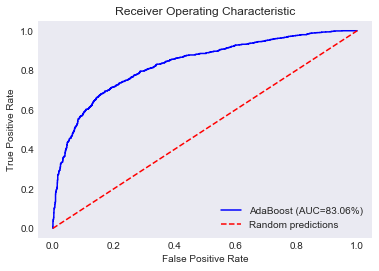

In [7]:
plot_roc_curve(classifiers, best_models, X_test, y_test_bins)

In [10]:
clf = best_models[0]
coef = pd.DataFrame(index=X_train.columns)
coef["Feature Importances"] = clf.feature_importances_
coef.sort_values("Feature Importances", ascending=False)

,Feature Importances
LotNr,0.247
Followers,0.235
SP.EV,0.097
Duration,0.094
EstValue,0.092
StartPrice,0.088
LotsCtgry,0.078
LotsSale,0.048
Forced,0.006
Afternoon,0.004
